In [1]:
import sys, os, importlib
from IPython.display import Image

In [2]:
sys.path.append(os.path.abspath('../'))

In [3]:
from wmhpypes.interfaces import ibbmTum
from wmhpypes.workflows import ibbmTum_wf
from wmhpypes.interfaces import cat12

2021-09-23 19:09:16.767414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-23 19:09:16.767461: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
from nipype import (DataGrabber, 
                    DataSink, 
                    IdentityInterface, 
                    MapNode, 
                    Workflow, 
                    Node)

In [5]:
from nipype.interfaces import fsl
from nipype.interfaces import spm
from nipype.algorithms.misc import Gunzip

In [19]:
data_source = Node(interface=IdentityInterface(fields=['flairs', 'wmh']),
                   name='data_source')
data_source.inputs.flairs = []
data_source.inputs.wmhs = []

In [8]:
# Preprocessing FLAIRS

bet = MapNode(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'),
              iterfield=['in_file'],
              name='bet')
denoising = MapNode(interface=cat12.CAT12SANLMDenoising(),
                    iterfield=['in_files'],
                    name='denoising')

stty: 'standard input': Inappropriate ioctl for device


In [13]:
train_preproc = MapNode(interface=ibbmTum.Preprocessing(rows_standard=192, 
                                                        cols_standard=192,
                                                        thres=10),
                        iterfield = 'flair',
                        name='train_preproc')


In [15]:
flair_preproc = Workflow(name='flair_preproc', base_dir='flair_preproc')
flair_preproc.connect(bet, 'out_file', denoising, 'in_files')
flair_preproc.connect(denoising, 'out_file', train_preproc, 'flair')

In [16]:
wmh_train_preproc = MapNode(interface=ibbmTum.Preprocessing(rows_standard=192, 
                                                        cols_standard=192,
                                                        thres=10),
                        iterfield = 'flair',
                        name='wmh_train_preproc')

In [17]:
train = Node(interface=ibbmTum.Train(), name='train')

In [20]:
train_wf = Workflow(name='train_wf', base_dir='train_wf')
train_wf.connect(data_source, 'flairs', flair_preproc, 'bet.in_file')
train_wf.connect(data_source, 'wmhs', wmh_train_preproc, 'flair')
train_wf.connect(flair_preproc, 'train_preproc.preprocessed_array', train, 'images')
train_wf.connect(wmh_train_preproc, 'preprocessed_array', train, 'masks')

In [24]:
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath('./out')
train_wf.connect(train, 'weights', sink, 'model.@weights')

210923-20:19:29,381 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/train_wf.png (graph2use=colored, simple_form=True).


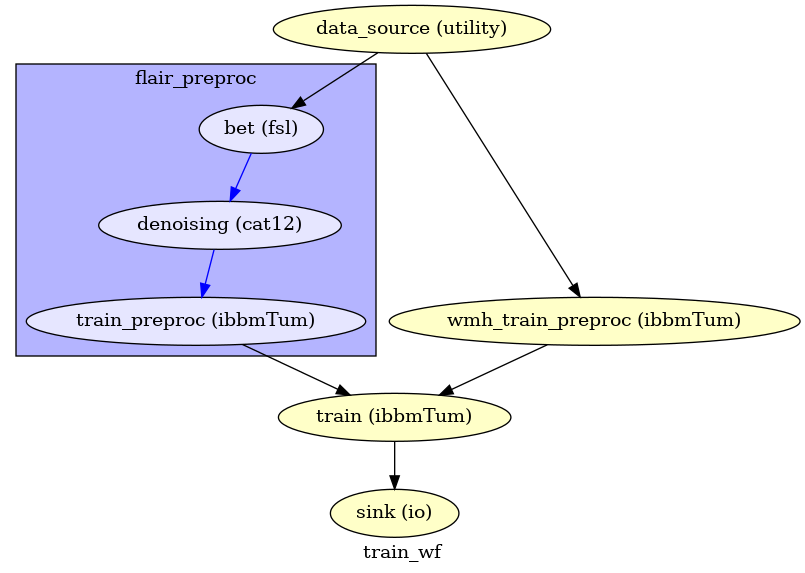

In [26]:
train_wf.write_graph(graph2use='colored', dotfilename='./imgs/train_wf.dot')
Image('./imgs/train_wf.png')